In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("../../hgrv_method/51Pegasi")
from spectra_functions import wave_match

In [2]:
%matplotlib notebook

In [3]:
temp = pd.read_csv("../../hgrv_method/51Pegasi/217014smoothtemp.csv")
ospec = pd.read_csv("217014_190605.1077ctd.csv")
#ospec = pd.read_csv("217014_191117.1084ctd.csv")

In [4]:
ospec = ospec.iloc[np.where((ospec.Wavelength.values >= 4850) &
                            (ospec.Wavelength.values <= 6800))[0]]

<IPython.core.display.Javascript object>


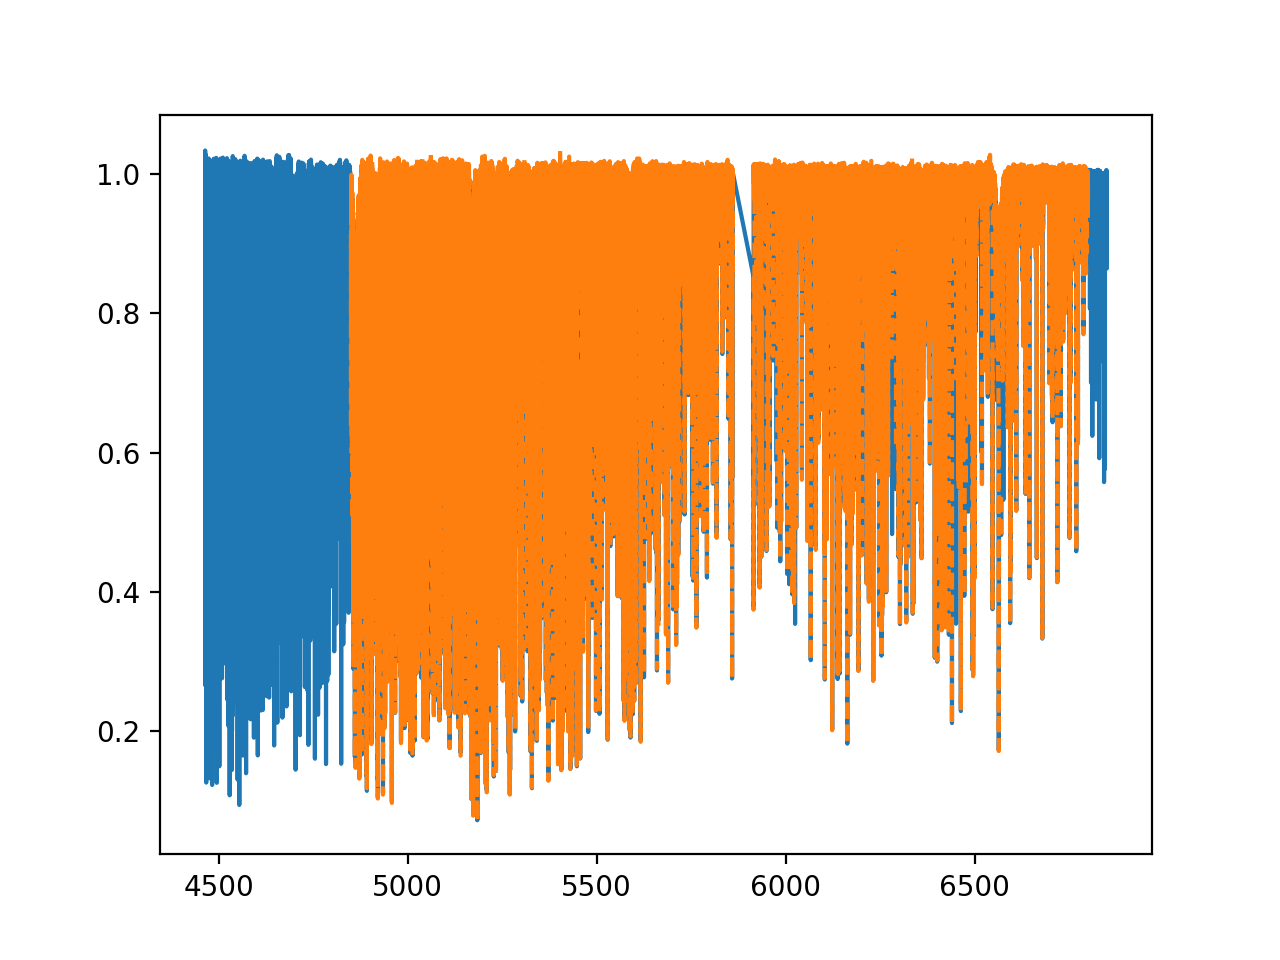

In [5]:
plt.plot(temp.Wavelength.values, temp.Flux.values)
plt.plot(ospec.Wavelength.values, ospec.Flux.values, ls='--')
plt.show()

In [5]:
ftrs = pd.read_csv("../../hgrv_method/51Pegasi/GoodFeatures.csv")

In [6]:
def hermitegauss1(x, mu, sig):
    z = (x - mu)/sig
    return 2*z*np.exp(-(z**2)/2)/np.sqrt(sig*2*np.sqrt(np.pi))

def lowerSNR(flux, sn):
    orig_mean = np.mean(flux)
    scaled_spec = np.array(flux)*(sn**2)/orig_mean
    return np.array(np.random.poisson(lam=scaled_spec, size=len(flux))*(orig_mean/(sn**2)))

In [7]:
hgrv = np.zeros(len(ospec.Wavelength.values))
#keep2 = []
for i in range(ftrs.shape[0]):
    keep = np.where((ospec.Wavelength.values >= ftrs.Gauss_mu.values[i] - 1) & 
                    (ospec.Wavelength.values <= ftrs.Gauss_mu.values[i] + 1))[0]
    #keep2 = keep2 + list(np.where((temp.Wavelength.values >= ftrs.Wv_lbounds.values[i]) & (temp.Wavelength.values <= ftrs.Wv_ubounds.values[i]))[0])
    coef = -np.sqrt(np.sqrt(np.pi))*ftrs.Gauss_mu.values[i]*ftrs.Gauss_amp.values[i]/(299792458*np.sqrt(2*ftrs.Gauss_sig.values[i]))
    hgrv[keep] = hgrv[keep] + coef*hermitegauss1(ospec.Wavelength.values[keep], ftrs.Gauss_mu.values[i], ftrs.Gauss_sig.values[i])

#keep2 = np.unique(keep2)

<IPython.core.display.Javascript object>


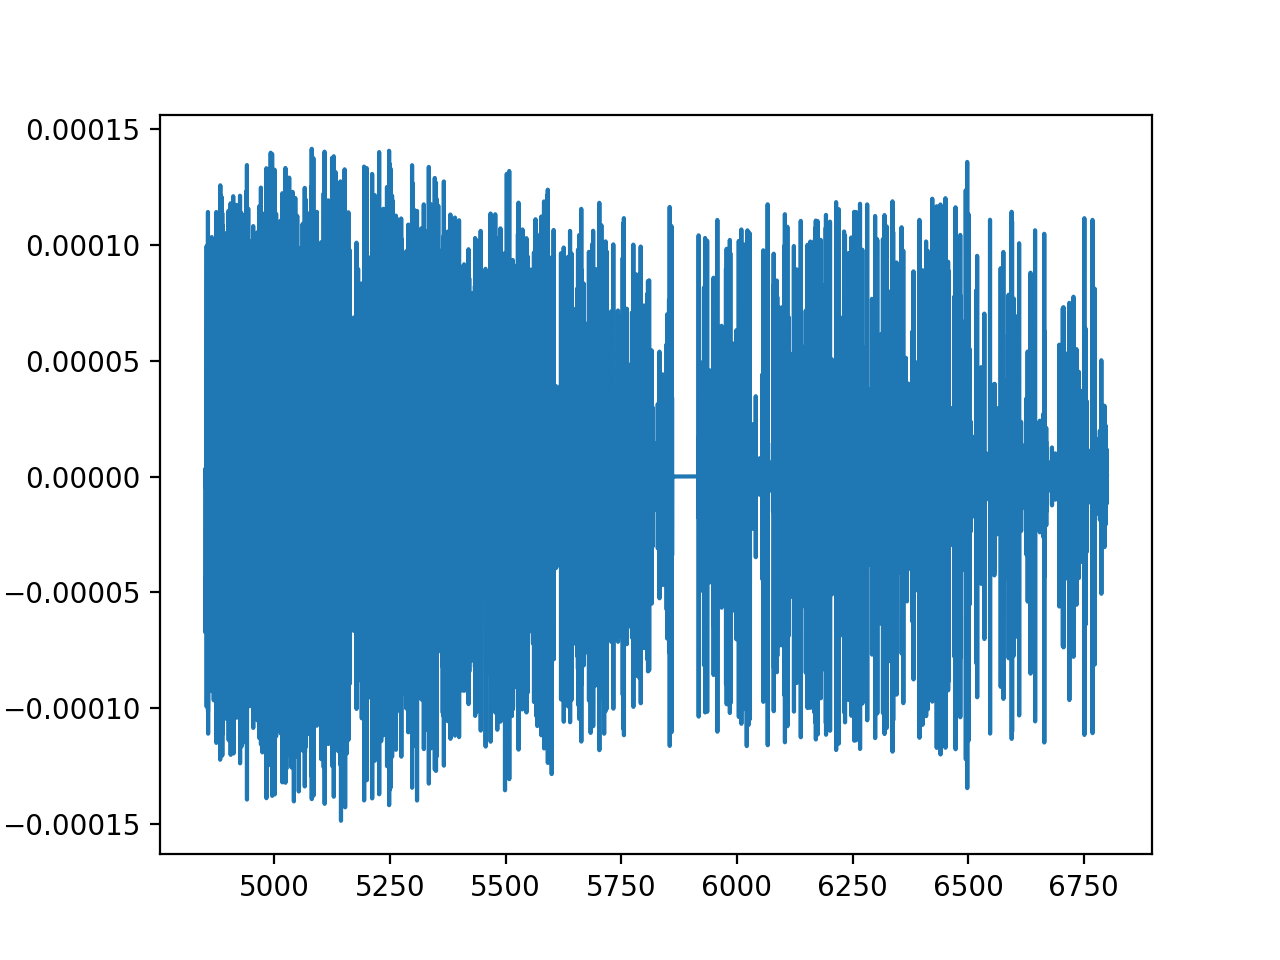

In [9]:
plt.plot(ospec.Wavelength.values, hgrv)
plt.show()

In [8]:
#limit to between 4850 and 6800 A
wvl = np.array(list(ospec.Wavelength.values))
tflx = wave_match(temp.Wavelength.values, temp.Flux.values, wvl)

#limit to wavelengths within absorption features
keep2 = []
cnt = []
for i in range(ftrs.shape[0]):
    more = np.where((wvl >= ftrs.Wv_lbounds.values[i]) & (wvl <= ftrs.Wv_ubounds.values[i]))[0]
    keep2 = keep2 + list(more)
    cnt.append(len(more))
keep2 = np.unique(keep2)
wvl = wvl[keep2]
tflx = tflx[keep2]
hgrv = hgrv[keep2]

In [9]:
len(cnt)
len(np.where(np.array(cnt) == 0)[0])

1393

<IPython.core.display.Javascript object>


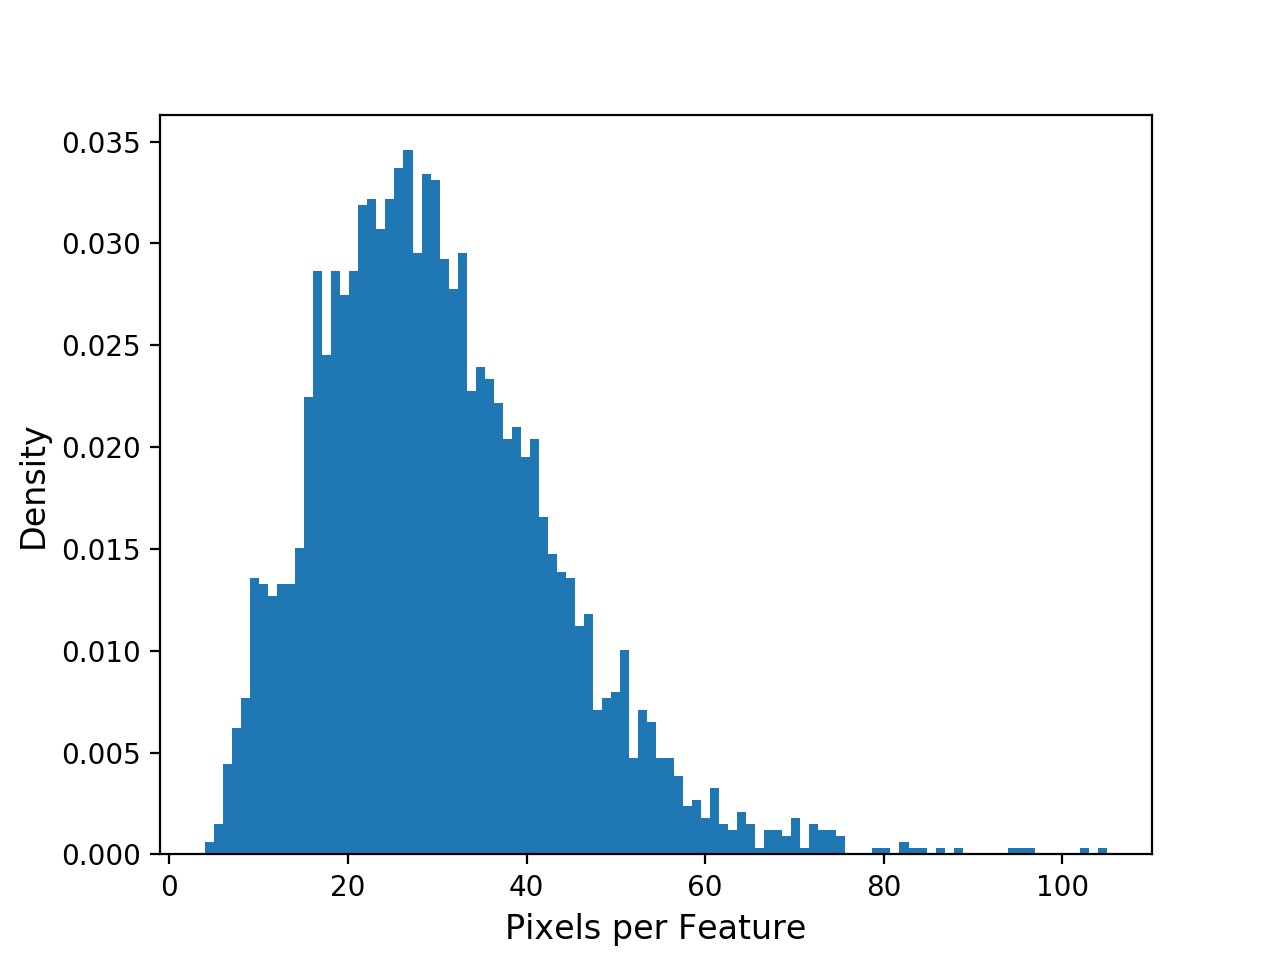

In [21]:
gd = np.where(np.array(cnt) > 0)[0]
plt.hist(np.array(cnt)[gd], bins=100, density=True)
plt.xlabel("Pixels per Feature", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.savefig("pixels_per_feature")
plt.show()

<IPython.core.display.Javascript object>


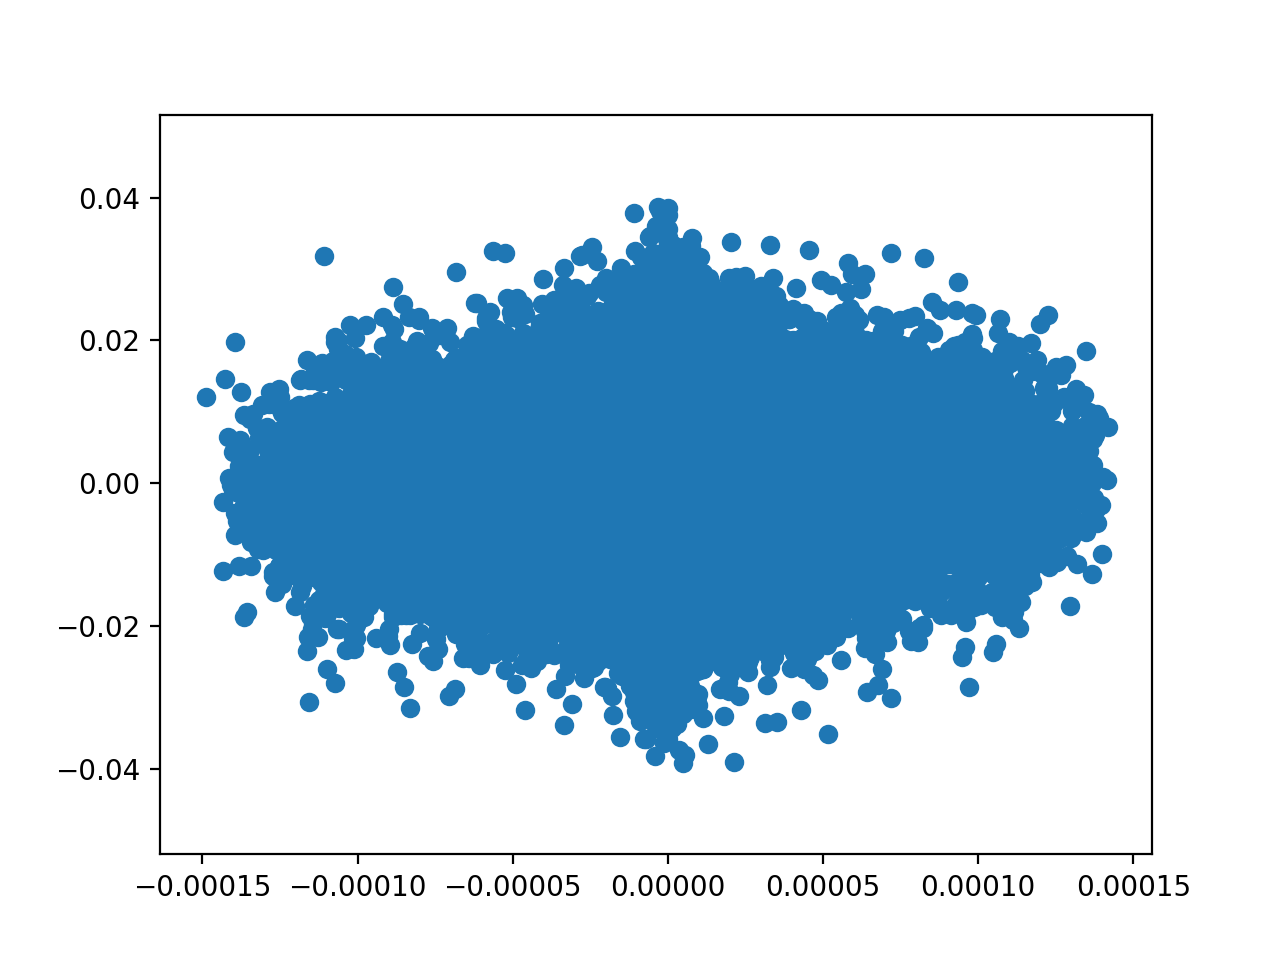

In [10]:
rv = 10
doppfact = 1 + rv/299792458

oflx = lowerSNR(wave_match(doppfact*temp.Wavelength.values, temp.Flux.values, ospec.Wavelength.values[keep2]), 100)

#mask out outliers
keep4 = np.where(np.absolute(oflx - tflx) < 0.05)[0]

plt.scatter(hgrv[keep4], oflx[keep4] - tflx[keep4])
plt.xlim(1.1*np.min(hgrv[keep4]), 1.1*np.max(hgrv[keep4]))
plt.show()

In [11]:
diff = oflx[keep4] - tflx[keep4]
wdiff = diff/np.sqrt(tflx[keep4])
whgrv = hgrv[keep4]/np.sqrt(tflx[keep4])
rv_hat = np.sum(wdiff*whgrv)/np.sum(whgrv**2)
rv_hat

9.512611559000613

In [12]:
resid = wdiff - rv_hat*whgrv
var_hat = np.sum(resid*resid)/(len(resid)-1)
rv_hat_sd = np.sqrt(var_hat/np.sum(whgrv**2))
rv_hat_sd

0.796008435935136

In [13]:
def rms(v, snr, n=1000):
    doppfact = 1 + v/299792458
    trueflx = wave_match(doppfact*temp.Wavelength.values, temp.Flux.values, ospec.Wavelength.values[keep2])
    #cutoff = 6*np.percentile(trueflx - tflx, 75) - 5*np.percentile(trueflx - tflx, 25)
    #keep4 = np.where(np.absolute(trueflx - tflx) < 0.03)[0]
    
    rvhats = []
    for i in range(n):
        oflx = lowerSNR(trueflx, snr)
        diff = oflx - tflx
        wdiff = diff/np.sqrt(tflx)
        whgrv = hgrv/np.sqrt(tflx)
        rvhats.append(np.sum(wdiff*whgrv)/np.sum(whgrv**2))
    
    return np.sqrt(np.mean((np.array(rvhats) - v)**2))

def estRV(v, snr, n=2000):
    doppfact = 1 + v/299792458
    trueflx = wave_match(doppfact*temp.Wavelength.values, temp.Flux.values, ospec.Wavelength.values[keep2])
    #cutoff = 6*np.percentile(trueflx - tflx, 75) - 5*np.percentile(trueflx - tflx, 25)
    #keep4 = np.where(np.absolute(trueflx - tflx) < 0.03)[0]
    
    rvhats = []
    for i in range(n):
        oflx = lowerSNR(trueflx, snr)
        diff = oflx - tflx
        wdiff = diff/np.sqrt(tflx)
        whgrv = hgrv/np.sqrt(tflx)
        rvhats.append(np.sum(wdiff*whgrv)/np.sum(whgrv**2))
    
    return np.array(rvhats)

In [42]:
RVs = estRV(100,300, n=2000)

In [43]:
bias = np.mean(RVs - 100)
bias

0.18530000915598127

In [44]:
var = np.mean((RVs - np.mean(RVs))**2)
np.sqrt(var)

0.2621853359753171

In [45]:
mse = np.mean((RVs - 100)**2)
np.sqrt(mse)

0.32105644954384055

In [46]:
df = pd.DataFrame({"RV": RVs})
df.to_csv("hgrv_sn300_rv100.csv")

In [20]:
check = pd.read_csv("ccf_sn200_rv50.csv").RV.values

In [21]:
np.sqrt(np.mean((check - 50)**2))

0.472387500599084

In [26]:
0.392459 - 0.48597

-0.09351100000000001

# Compare HGRV and CCF

In [3]:
snr = [100, 150, 200, 250, 300]
v = ['0.01', '0.1', '1', '10', '100']
hgrv_bias = np.zeros((5,5))
hgrv_var = np.zeros((5,5))
hgrv_mse = np.zeros((5,5))
ccf_bias = np.zeros((5,5))
ccf_var = np.zeros((5,5))
ccf_mse = np.zeros((5,5))
for i in range(len(v)):
    for j in range(len(snr)):
        hgrv = pd.read_csv("hgrv_sn%d_rv%s.csv"%(snr[j], v[i])).RV.values
        ccf = pd.read_csv("ccf_sn%d_rv%s.csv"%(snr[j], v[i])).RV.values
        hgrv_bias[i,j] = np.mean(hgrv - float(v[i]))
        ccf_bias[i,j] = np.mean(ccf - float(v[i]))
        hgrv_var[i,j] = np.mean((hgrv - np.mean(hgrv))**2)
        ccf_var[i,j] = np.mean((ccf - np.mean(ccf))**2)
        hgrv_mse[i,j] = np.mean((hgrv - float(v[i]))**2)
        ccf_mse[i,j] = np.mean((ccf - float(v[i]))**2)

<IPython.core.display.Javascript object>


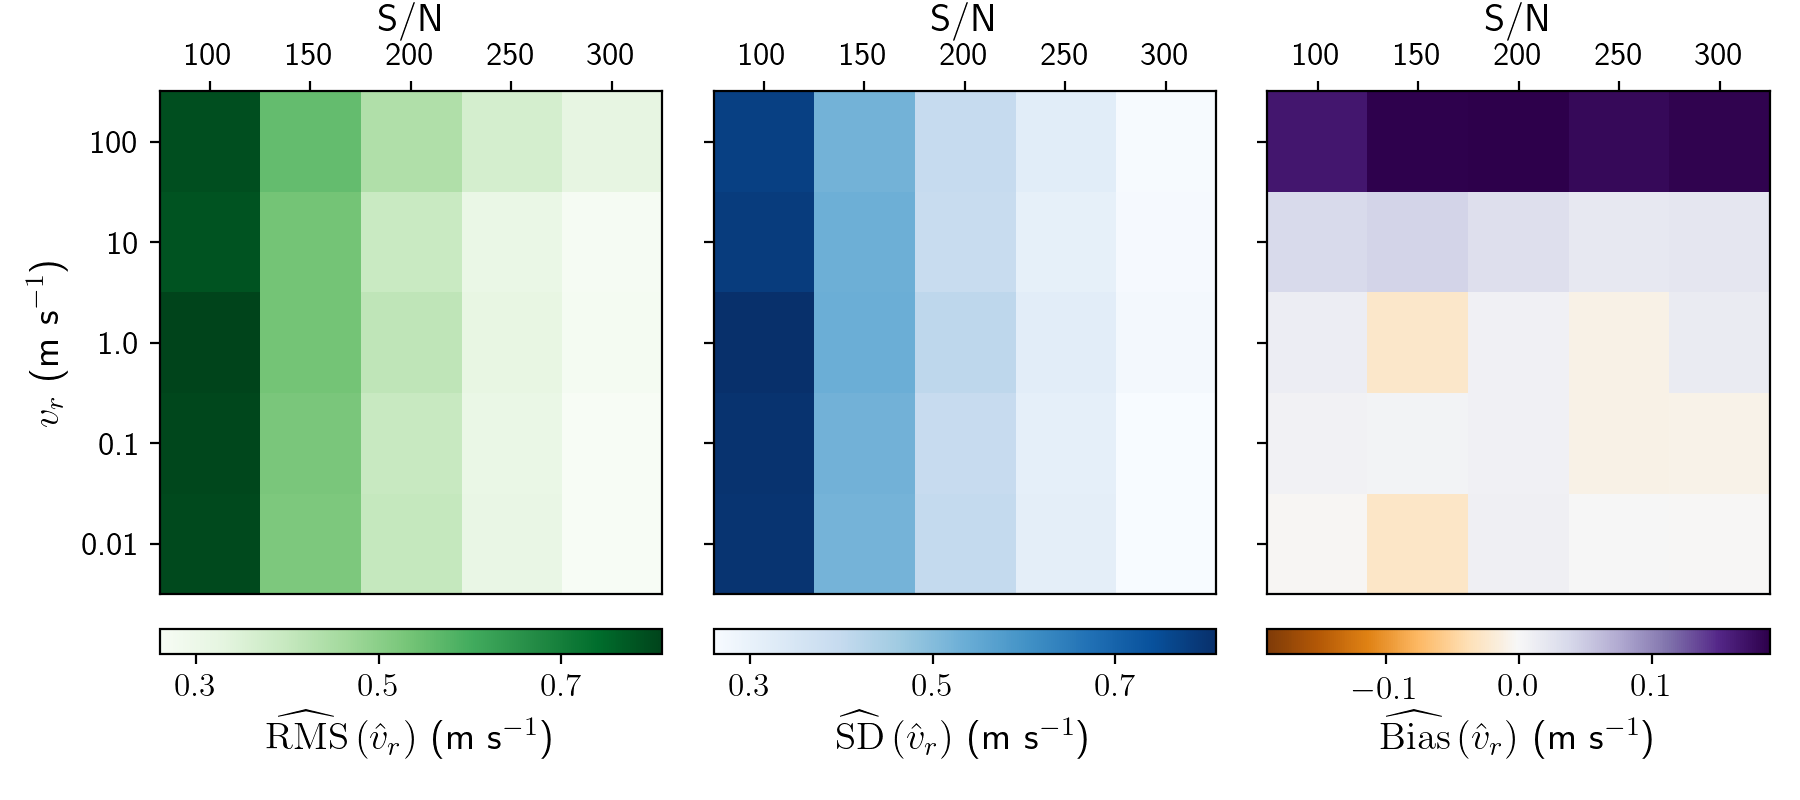

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9,4))
plt.rc('text', usetex=True)
im = ax[0].imshow(np.sqrt(hgrv_mse), cmap = 'Greens', origin='lower')
ytck = np.arange(len(v))
xtck = np.arange(len(snr))
ax[0].xaxis.set_label_position('top')
ax[0].xaxis.set_ticks_position('top')
ax[0].set_xticks(xtck)
ax[0].set_xticklabels(["%s"%(100 + 50*t) for t in xtck], fontsize=12)
ax[0].set_yticks(ytck)
ax[0].set_yticklabels(['0.01', '0.1', '1.0', '10', '100'], fontsize=12)
ax[0].set_ylabel(r"$v_{r}$ (m s$^{-1}$)", fontsize=14)
ax[0].set_xlabel("S/N", fontsize=14)
cbar = fig.colorbar(im, ax=ax[0], orientation='horizontal', pad=0.05)
cbar.set_label(r"$\widehat{\mathrm{RMS}}\left( \hat{v}_{r} \right)$ (m s$^{-1}$)", fontsize=14)
cbar.set_ticks([0.3, 0.5, 0.7])
cbar.ax.tick_params(labelsize=12)

im = ax[1].imshow(np.sqrt(hgrv_var), cmap = 'Blues', origin='lower')
ytck = np.arange(len(v))
xtck = np.arange(len(snr))
ax[1].xaxis.set_label_position('top')
ax[1].xaxis.set_ticks_position('top')
ax[1].set_xticks(xtck)
ax[1].set_xticklabels(["%s"%(100 + 50*t) for t in xtck], fontsize=12)
ax[1].set_yticks(ytck)
ax[1].set_yticklabels(['']*4, fontsize=12)
ax[1].set_xlabel("S/N", fontsize=14)
cbar = fig.colorbar(im, ax=ax[1], orientation='horizontal', pad=0.05)
cbar.set_label(r"$\widehat{\mathrm{SD}}\left( \hat{v}_{r} \right)$ (m s$^{-1}$)", fontsize=14)
cbar.set_ticks([0.3, 0.5, 0.7])
cbar.ax.tick_params(labelsize=12)

im = ax[2].imshow(hgrv_bias, cmap = 'PuOr', origin='lower')
ytck = np.arange(len(v))
xtck = np.arange(len(snr))
ax[2].xaxis.set_label_position('top')
ax[2].xaxis.set_ticks_position('top')
ax[2].set_xticks(xtck)
ax[2].set_xticklabels(["%s"%(100 + 50*t) for t in xtck], fontsize=12)
ax[2].set_yticks(ytck)
ax[2].set_yticklabels(['']*4, fontsize=12)
ax[2].set_xlabel("S/N", fontsize=14)
im.set_clim(-np.max([-np.min(hgrv_bias), np.max(hgrv_bias)]), np.max([-np.min(hgrv_bias), np.max(hgrv_bias)]))
cbar = fig.colorbar(im, ax=ax[2], orientation='horizontal', pad=0.05)
cbar.set_label(r"$\widehat{\mathrm{Bias}}\left( \hat{v}_{r} \right)$ (m s$^{-1}$)", fontsize=14)
cbar.ax.tick_params(labelsize=12)

plt.tight_layout(w_pad=1.5)
plt.savefig("HGRV_rms")
plt.show()

<IPython.core.display.Javascript object>


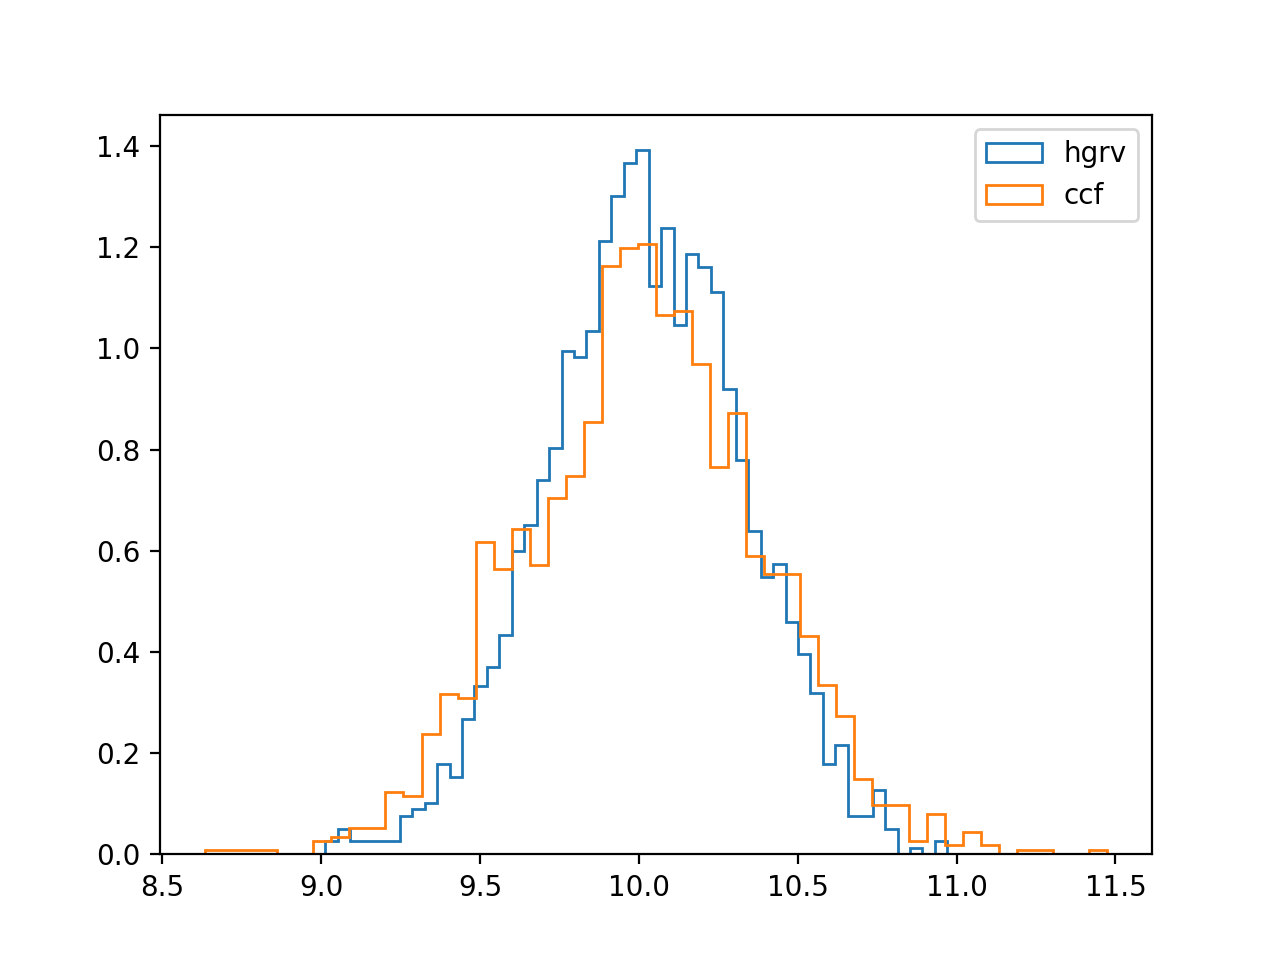

In [24]:
i = 3
j = 2
hgrv = pd.read_csv("hgrv_sn%d_rv%s.csv"%(snr[j], v[i])).RV.values
ccf = pd.read_csv("ccf_sn%d_rv%s.csv"%(snr[j], v[i])).RV.values
plt.hist(hgrv, bins=50, histtype='step', label='hgrv', density=True)
plt.hist(ccf, bins=50, histtype='step', label='ccf', density=True)
plt.legend(loc='best')
plt.show()

In [27]:
print(np.sqrt(hgrv_var[i,j]), np.sqrt(ccf_var[i,j]))

0.30677992772608753 0.36944184036589267


<IPython.core.display.Javascript object>


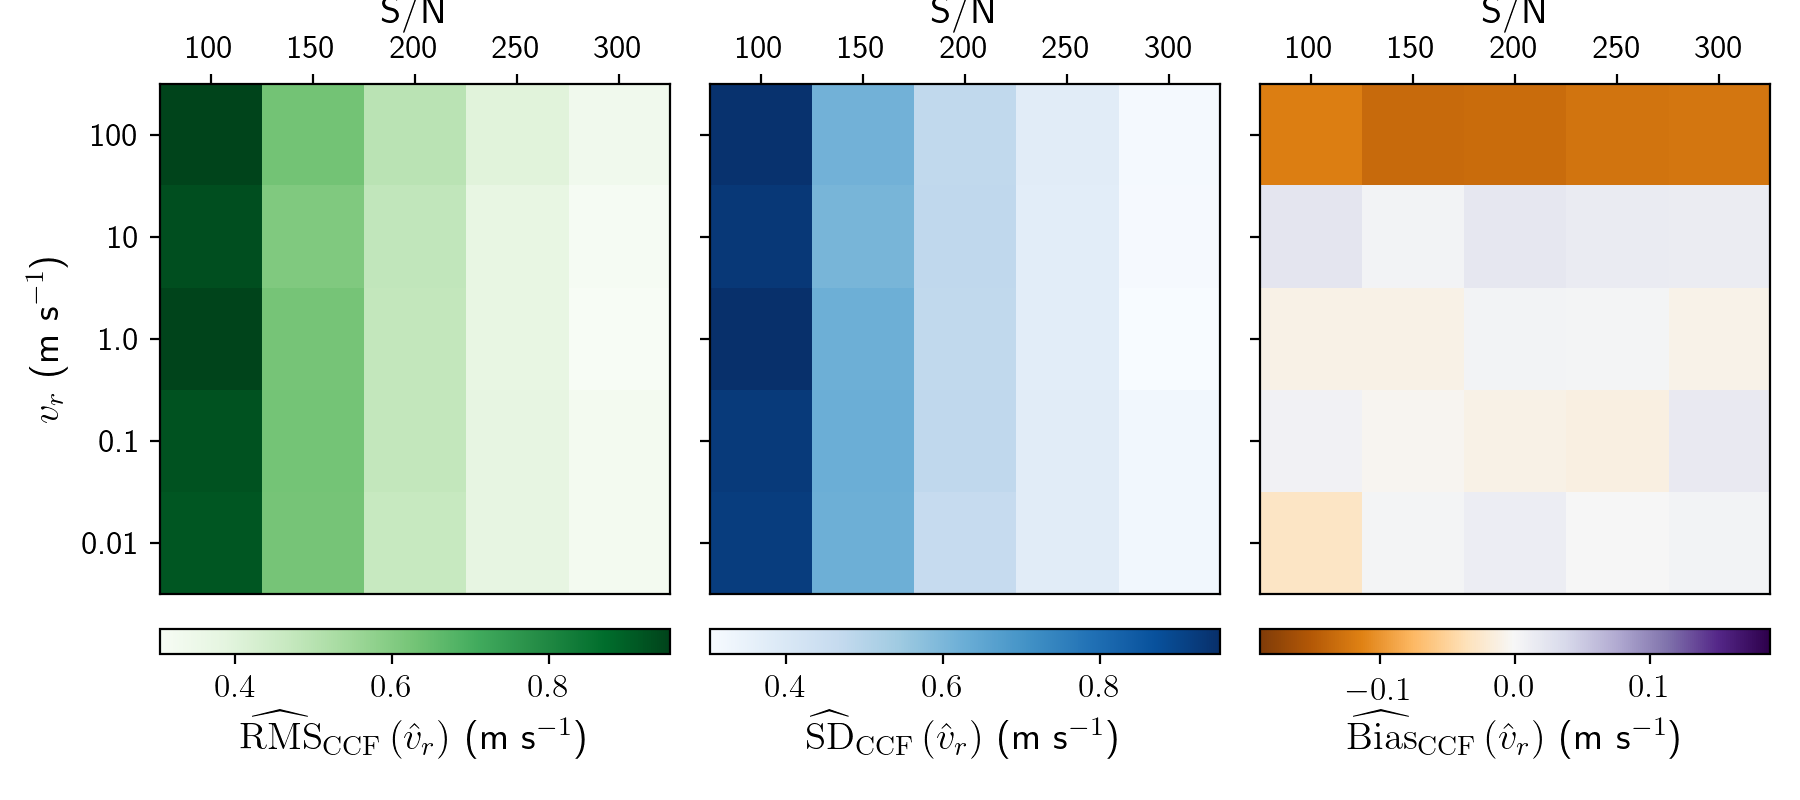

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9,4))
plt.rc('text', usetex=True)
im = ax[0].imshow(np.sqrt(ccf_mse), cmap = 'Greens', origin='lower')
ytck = np.arange(len(v))
xtck = np.arange(len(snr))
ax[0].xaxis.set_label_position('top')
ax[0].xaxis.set_ticks_position('top')
ax[0].set_xticks(xtck)
ax[0].set_xticklabels(["%s"%(100 + 50*t) for t in xtck], fontsize=12)
ax[0].set_yticks(ytck)
ax[0].set_yticklabels(['0.01', '0.1', '1.0', '10', '100'], fontsize=12)
ax[0].set_ylabel(r"$v_{r}$ (m s$^{-1}$)", fontsize=14)
ax[0].set_xlabel("S/N", fontsize=14)
cbar = fig.colorbar(im, ax=ax[0], orientation='horizontal', pad=0.05)
cbar.set_label(r"$\widehat{\mathrm{RMS}}_{\mathrm{CCF}} \left( \hat{v}_{r} \right)$ (m s$^{-1}$)", fontsize=14)
#cbar.set_ticks([0.3, 0.5, 0.7])
cbar.ax.tick_params(labelsize=12)

im = ax[1].imshow(np.sqrt(ccf_var), cmap = 'Blues', origin='lower')
ytck = np.arange(len(v))
xtck = np.arange(len(snr))
ax[1].xaxis.set_label_position('top')
ax[1].xaxis.set_ticks_position('top')
ax[1].set_xticks(xtck)
ax[1].set_xticklabels(["%s"%(100 + 50*t) for t in xtck], fontsize=12)
ax[1].set_yticks(ytck)
ax[1].set_yticklabels(['']*4, fontsize=12)
ax[1].set_xlabel("S/N", fontsize=14)
cbar = fig.colorbar(im, ax=ax[1], orientation='horizontal', pad=0.05)
cbar.set_label(r"$\widehat{\mathrm{SD}}_{\mathrm{CCF}} \left( \hat{v}_{r} \right)$ (m s$^{-1}$)", fontsize=14)
#cbar.set_ticks([0.3, 0.5, 0.7])
cbar.ax.tick_params(labelsize=12)

im = ax[2].imshow(ccf_bias, cmap = 'PuOr', origin='lower')
ytck = np.arange(len(v))
xtck = np.arange(len(snr))
ax[2].xaxis.set_label_position('top')
ax[2].xaxis.set_ticks_position('top')
ax[2].set_xticks(xtck)
ax[2].set_xticklabels(["%s"%(100 + 50*t) for t in xtck], fontsize=12)
ax[2].set_yticks(ytck)
ax[2].set_yticklabels(['']*4, fontsize=12)
ax[2].set_xlabel("S/N", fontsize=14)
im.set_clim(-np.max([-np.min(hgrv_bias), np.max(hgrv_bias)]), np.max([-np.min(hgrv_bias), np.max(hgrv_bias)]))
cbar = fig.colorbar(im, ax=ax[2], orientation='horizontal', pad=0.05)
cbar.set_label(r"$\widehat{\mathrm{Bias}}_{\mathrm{CCF}} \left( \hat{v}_{r} \right)$ (m s$^{-1}$)", fontsize=14)
cbar.ax.tick_params(labelsize=12)

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


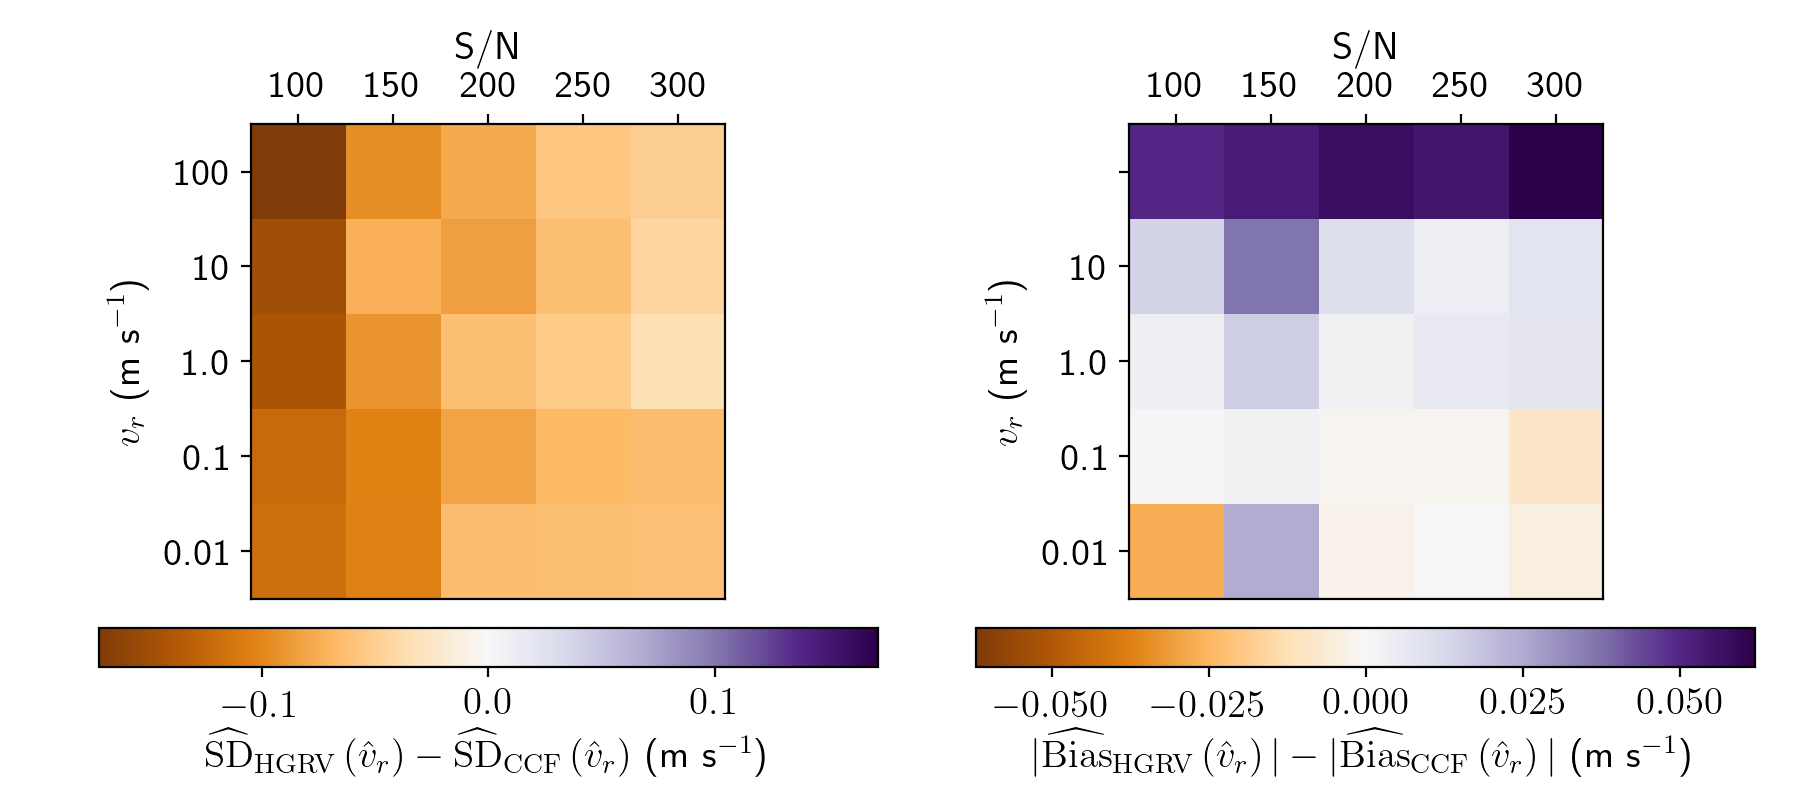

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,4))
plt.rc('text', usetex=True)
im = ax[0].imshow(np.sqrt(hgrv_var) - np.sqrt(ccf_var), cmap = 'PuOr', origin='lower')
ytck = np.arange(len(v))
xtck = np.arange(len(snr))
ax[0].xaxis.set_label_position('top')
ax[0].xaxis.set_ticks_position('top')
ax[0].set_xticks(xtck)
ax[0].set_xticklabels(["%s"%(100 + 50*t) for t in xtck], fontsize=14)
ax[0].set_yticks(ytck)
ax[0].set_yticklabels(['0.01', '0.1', '1.0', '10', '100'], fontsize=14)
ax[0].set_ylabel(r"$v_{r}$ (m s$^{-1}$)", fontsize=14)
ax[0].set_xlabel("S/N", fontsize=14)
diff = np.sqrt(hgrv_var) - np.sqrt(ccf_var)
im.set_clim(-np.max([-np.min(diff), np.max(diff)]), np.max([-np.min(diff), np.max(diff)]))
cbar = fig.colorbar(im, ax=ax[0], orientation='horizontal', pad=0.05)
cbar.set_label(r"$\widehat{\mathrm{SD}}_{\mathrm{HGRV}} \left( \hat{v}_{r} \right) - \widehat{\mathrm{SD}}_{\mathrm{CCF}} \left( \hat{v}_{r} \right)$ (m s$^{-1}$)", 
               fontsize=14)
#cbar.set_ticks([0.3, 0.5, 0.7])
cbar.ax.tick_params(labelsize=14)

#im = ax[1].imshow(np.sqrt(hgrv_var) - np.sqrt(ccf_var), cmap = 'PuOr', origin='lower')
#ytck = np.arange(len(v))
#xtck = np.arange(len(snr))
#ax[1].xaxis.set_label_position('top')
#ax[1].xaxis.set_ticks_position('top')
#ax[1].set_xticks(xtck)
#ax[1].set_xticklabels(["%s"%(100 + 50*t) for t in xtck], fontsize=12)
#ax[1].set_yticks(ytck)
#ax[1].set_yticklabels(['']*4, fontsize=12)
#ax[1].set_xlabel("S/N", fontsize=14)
#diff = np.sqrt(hgrv_var) - np.sqrt(ccf_var)
#im.set_clim(-np.max([-np.min(diff), np.max(diff)]), np.max([-np.min(diff), np.max(diff)]))
#cbar = fig.colorbar(im, ax=ax[1], orientation='horizontal', pad=0.05)
#cbar.set_label(r"$\widehat{\mathrm{SD}}_{\mathrm{HGRV}} \left( \hat{v}_{r} \right) - \widehat{\mathrm{SD}}_{\mathrm{CCF}} \left( \hat{v}_{r} \right)$ (m s$^{-1}$)", fontsize=14)
##cbar.set_ticks([0.3, 0.5, 0.7])
#cbar.ax.tick_params(labelsize=12)

im = ax[1].imshow(np.absolute(hgrv_bias) - np.absolute(ccf_bias), cmap = 'PuOr', origin='lower')
ytck = np.arange(len(v))
xtck = np.arange(len(snr))
ax[1].xaxis.set_label_position('top')
ax[1].xaxis.set_ticks_position('top')
ax[1].set_xticks(xtck)
ax[1].set_xticklabels(["%s"%(100 + 50*t) for t in xtck], fontsize=14)
ax[1].set_yticks(ytck)
ax[1].set_yticklabels(['0.01', '0.1', '1.0', '10'], fontsize=14)
ax[1].set_ylabel(r"$v_{r}$ (m s$^{-1}$)", fontsize=14)
ax[1].set_xlabel("S/N", fontsize=14)
diff = np.absolute(hgrv_bias) - np.absolute(ccf_bias)
im.set_clim(-np.max([-np.min(diff), np.max(diff)]), np.max([-np.min(diff), np.max(diff)]))
cbar = fig.colorbar(im, ax=ax[1], orientation='horizontal', pad=0.05)
cbar.set_label(r"$|\widehat{\mathrm{Bias}}_{\mathrm{HGRV}} \left( \hat{v}_{r} \right)| - |\widehat{\mathrm{Bias}}_{\mathrm{CCF}} \left( \hat{v}_{r} \right)|$ (m s$^{-1}$)", fontsize=14)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
plt.savefig("hgrv_ccf_varbiasdiff")
plt.show()

<IPython.core.display.Javascript object>


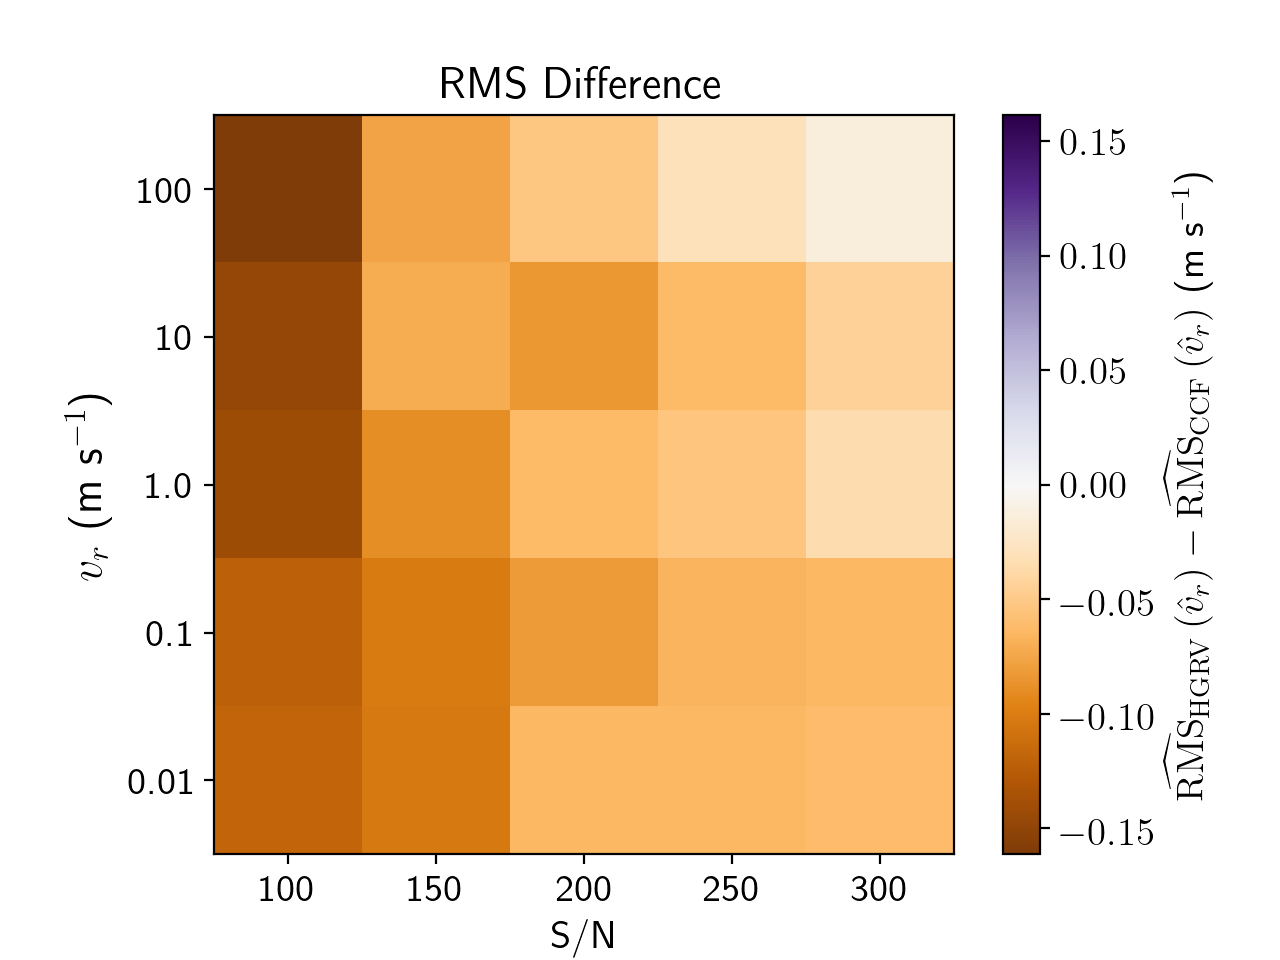

In [14]:
plt.rc('text', usetex=True)
plt.imshow(np.sqrt(hgrv_mse) - np.sqrt(ccf_mse), cmap = 'PuOr', origin='lower')
scale = np.max(np.max(np.absolute(np.sqrt(hgrv_mse) - np.sqrt(ccf_mse))))
plt.clim(-scale, scale)
plt.xticks(ticks = xtck, labels = ["%s"%(100 + 50*t) for t in xtck], fontsize=14)
plt.yticks(ticks = ytck, labels = ['0.01', '0.1', '1.0', '10', '100'], fontsize=14)
plt.xlabel(r"S/N", fontsize=14)
plt.ylabel(r"$v_{r}$ (m s$^{-1}$)", fontsize=16)
plt.title("RMS Difference", fontsize=16)
cbar = plt.colorbar()
cbar.set_label(r"$\widehat{\mathrm{RMS}}_{\mathrm{HGRV}} \left( \hat{v}_{r} \right) - \widehat{\mathrm{RMS}}_{\mathrm{CCF}} \left( \hat{v}_{r} \right)$ (m s$^{-1}$)", fontsize=14)
cbar.ax.tick_params(labelsize=14)

plt.savefig("HGRV_CCF_rmsdiff")
plt.show()

<IPython.core.display.Javascript object>


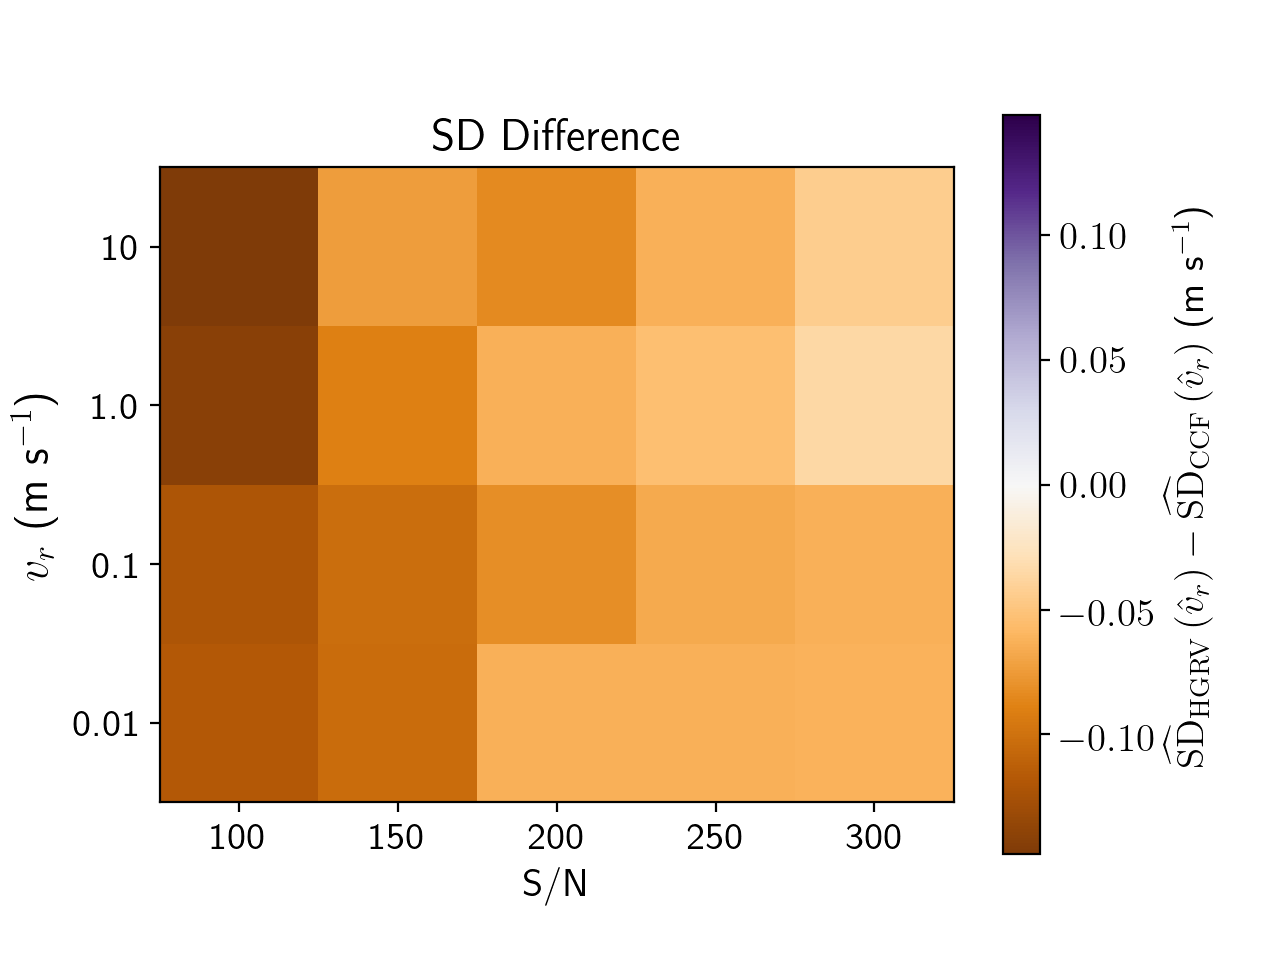

In [75]:
plt.rc('text', usetex=True)
plt.imshow(np.sqrt(hgrv_var) - np.sqrt(ccf_var), cmap = 'PuOr', origin='lower')
scale = np.max(np.max(np.absolute(np.sqrt(hgrv_var) - np.sqrt(ccf_var))))
plt.clim(-scale, scale)
plt.xticks(ticks = xtck, labels = ["%s"%(100 + 50*t) for t in xtck], fontsize=14)
plt.yticks(ticks = ytck, labels = ['0.01', '0.1', '1.0', '10'], fontsize=14)
plt.xlabel(r"S/N", fontsize=14)
plt.ylabel(r"$v_{r}$ (m s$^{-1}$)", fontsize=16)
plt.title("SD Difference", fontsize=16)
cbar = plt.colorbar()
cbar.set_label(r"$\widehat{\mathrm{SD}}_{\mathrm{HGRV}} \left( \hat{v}_{r} \right) - \widehat{\mathrm{SD}}_{\mathrm{CCF}} \left( \hat{v}_{r} \right)$ (m s$^{-1}$)", fontsize=14)
cbar.ax.tick_params(labelsize=14)

plt.show()

<IPython.core.display.Javascript object>


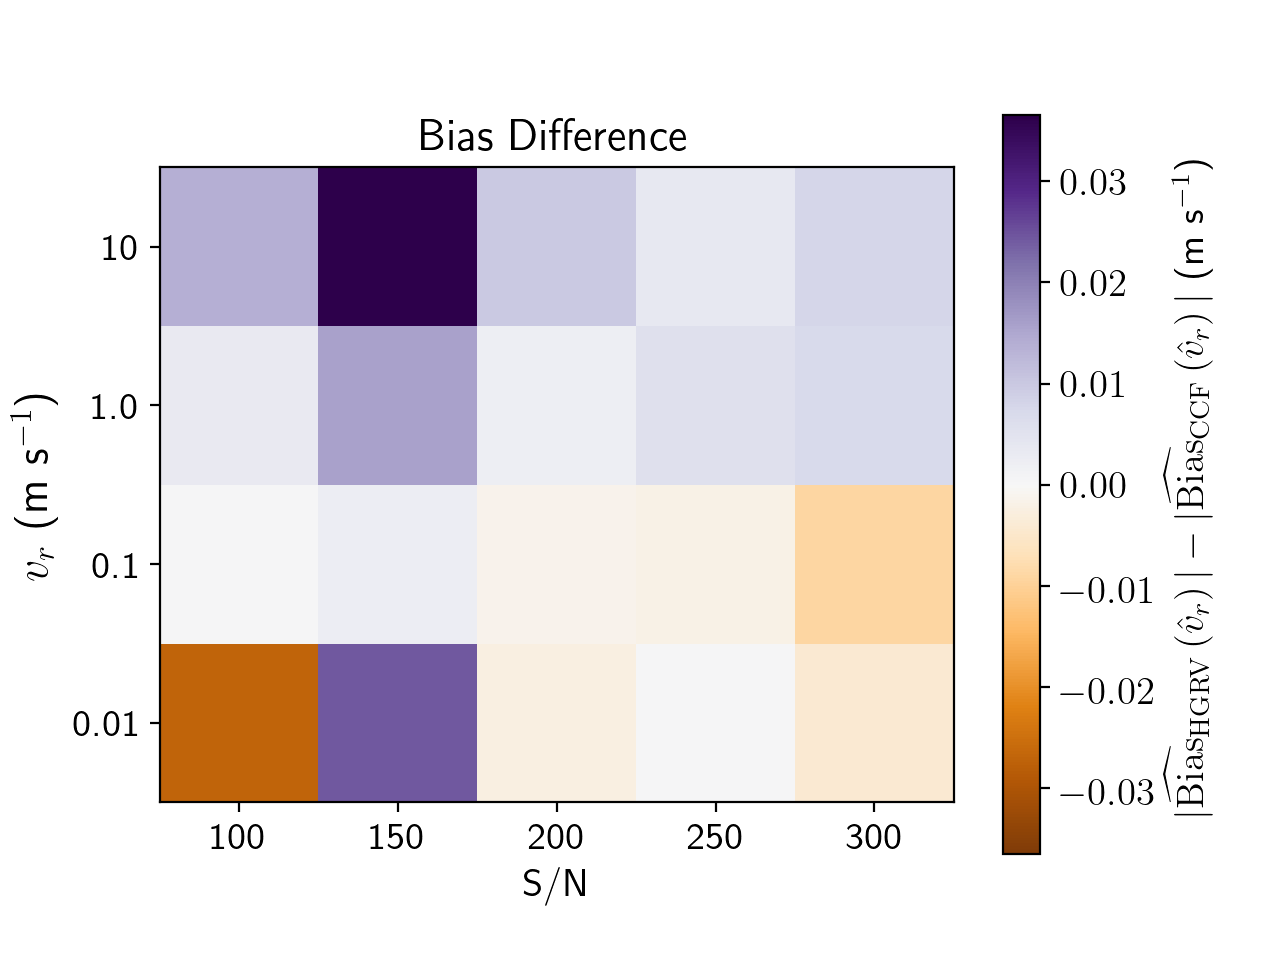

In [76]:
plt.rc('text', usetex=True)
plt.imshow(np.absolute(hgrv_bias) - np.absolute(ccf_bias), cmap = 'PuOr', origin='lower')
scale = np.max(np.max(np.absolute(np.absolute(hgrv_bias) - np.absolute(ccf_bias))))
plt.clim(-scale, scale)
plt.xticks(ticks = xtck, labels = ["%s"%(100 + 50*t) for t in xtck], fontsize=14)
plt.yticks(ticks = ytck, labels = ['0.01', '0.1', '1.0', '10'], fontsize=14)
plt.xlabel(r"S/N", fontsize=14)
plt.ylabel(r"$v_{r}$ (m s$^{-1}$)", fontsize=16)
plt.title("Bias Difference", fontsize=16)
cbar = plt.colorbar()
cbar.set_label(r"$|\widehat{\mathrm{Bias}}_{\mathrm{HGRV}} \left( \hat{v}_{r} \right)| - |\widehat{\mathrm{Bias}}_{\mathrm{CCF}} \left( \hat{v}_{r} \right)|$ (m s$^{-1}$)", fontsize=14)
cbar.ax.tick_params(labelsize=14)

plt.show()